# analyze each cell

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import pysta
import stc
import stcl
%load_ext autoreload
%autoreload 2

## To Do
1. visualization: plot un-related stims (black dots)
  * boosting?
  * gray code
  * typical sequence
2. apply techniques: https://github.com/ys7yoo/hands-on/blob/master/anomaly_comparison.ipynb
  * robust covariance: uni-modal
  * GMM: multi-modal
  * isolation forest: more complex RFs

In [2]:
# load stim and spike data
dataset_name = "20180626"
data_filename = "data/{}.mat".format(dataset_name)

stim, spike_train, info = pysta.load_data(data_filename)

info["channel_names"]

dt = 1000/info["sampling_rate"] # in ms

List of arrays in this file: 
 <KeysViewHDF5 ['#refs#', 'channel_names', 'height', 'sampling_rate', 'spike_train', 'stim', 'width']>
Shape of the array stim:  (64, 9000)
Shape of the array spike_train:  (156, 9000)
length of the list channel_names:  156
sampling_rate:  10.0


In [3]:
# load cell type
cell_type = pd.read_csv("data/20180626_cell_type.csv")

(array([14.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0., 19.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

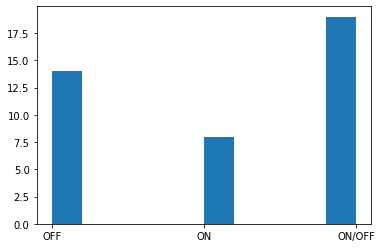

In [4]:
#cell_type["cell_type"].hist()
plt.hist(cell_type["cell_type"])

[8, 14, 19]


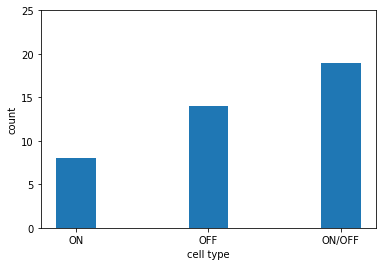

In [5]:
# re-plot with the order that I WANT
# https://stackoverflow.com/questions/28418988/how-to-make-a-histogram-from-a-list-of-strings-in-python
from collections import Counter
cell_type_counts = Counter(cell_type["cell_type"])

types=["ON", "OFF", "ON/OFF"]
cell_type_counts = [cell_type_counts[type] for type in types]
print(cell_type_counts)

plt.figure(figsize=(6,4))
plt.bar(types, cell_type_counts, width=0.3)
plt.ylim(0,25)
plt.ylabel('count')
plt.xlabel('cell type')


result_folder_name = "result_{}".format(dataset_name)
if not os.path.exists(result_folder_name):
    os.makedirs(result_folder_name)

plt.savefig(os.path.join(result_folder_name, "cell_type_count.pdf"))
plt.savefig(os.path.join(result_folder_name, "cell_type_count.png"))

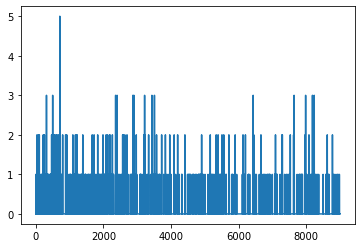

In [6]:
# chose a cell to anlayze
#channel_name = "14b"  # OFF cell

channel_name = "22a" # ON/OFF
#channel_name = "22b" # ON/OFF two significant eigenvalues
# channel_name = "36c" # ON/OFF 
channel_name = "74b" # ON/OFF, very large kurtosis
idx = pysta.find_channel_index(info["channel_names"], channel_name)

stim.shape
plt.plot(spike_train[idx])

## grab spike-trigerred stim

In [99]:
# grab spike-trigerred stim
#tap = 10
# tap = 6 # -500ms ~ 0
#tap = 7 # -600 ms ~ 0
tap = 8 # -700 ms ~ 0
spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[idx], tap)
print(spike_triggered_stim.shape)
print(spike_count.shape)
print(np.sum(spike_count))

(381, 64, 8)
(381,)
483


In [57]:
if spike_triggered_stim.shape[0] < spike_triggered_stim.shape[1]*spike_triggered_stim.shape[2]:
    print("[WARNING] NOT ENOUGH SPIKES!")

[WARNING] NOT ENOUGH SPIKES!


## STA

In [58]:
# sta
sta = np.average(spike_triggered_stim, weights=spike_count, axis=0)
# sta = np.mean(spike_triggered_stim, axis=0)
sta.shape

(64, 8)

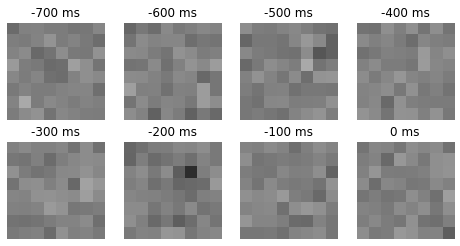

In [59]:
pysta.plot_stim_slices(sta, dt=100)

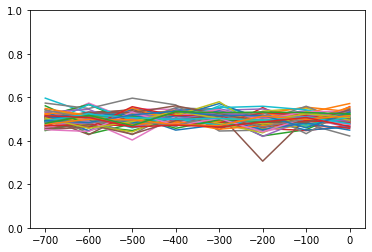

In [60]:
grid_T = np.linspace(-tap+1,0,tap)*dt
plt.plot(grid_T, sta.T)
plt.ylim([0, 1])
plt.savefig(os.path.join(result_folder_name, "{}_sta.pdf".format(channel_name)))

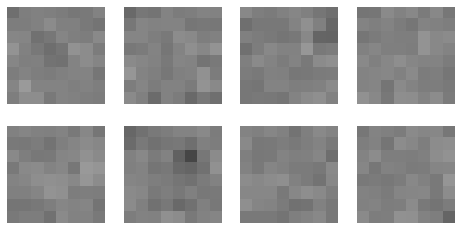

In [61]:
sig=0.5
pysta.plot_stim_slices(pysta.smoothe_each_slice(sta,sigma=sig))

(0, 1)

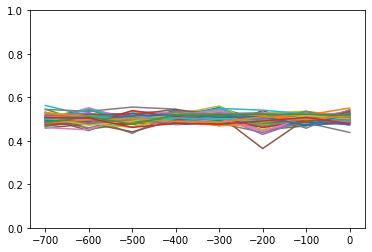

In [62]:
#pysta.smoothe_each_slice(sta).shape
plt.plot(grid_T, pysta.smoothe_each_slice(sta, sigma=sig).T)
plt.ylim([0, 1])

In [63]:
spike_triggered_stim.shape

(381, 64, 8)

## smooth stim

In [64]:
## smooth stim
num_samples = spike_triggered_stim.shape[0]
sig=np.sqrt(0.25)
smoothed_spike_triggered_stim = [pysta.smoothe_each_slice(spike_triggered_stim[i,:,:],sigma=sig) for i in range(num_samples)]
smoothed_spike_triggered_stim = np.array(smoothed_spike_triggered_stim)

In [65]:
smoothed_spike_triggered_stim.shape

(381, 64, 8)

In [66]:
# smoothted
spike_triggered_stim_row = smoothed_spike_triggered_stim.reshape([num_samples,-1])
# un-smoothed
# spike_triggered_stim_row = spike_triggered_stim.reshape([num_samples,-1])
spike_triggered_stim_row.shape

(381, 512)

In [67]:
## PCA
from sklearn.decomposition import PCA

# pca = PCA(n_components = 2)
# projected = pca.fit_transform(spike_triggered_stim_row)

dim = spike_triggered_stim_row.shape[1]
center = 0.5*np.ones((1,dim))


pca = PCA(whiten=True)
#pca = PCA(n_components = 2, whiten=True)
projected = pca.fit_transform(spike_triggered_stim_row-center)
# projected += pca.transform(center)

In [95]:
# switch to my code

cov0 = stc.calc_covariance_matrix(spike_triggered_stim_row-center)
cov1 = stc.calc_covariance_matrix(spike_triggered_stim_row-center, spike_count)
cov2 = stc.calc_covariance_matrix(spike_triggered_stim_row-center, centered=True)
cov3 = stc.calc_covariance_matrix(spike_triggered_stim_row-center, spike_count, centered=True)  # <= I will use this

# robust covariance
cov4 = stc.calc_robust_covariance_matrix(spike_triggered_stim_row-center, centered=True)
cov5 = stc.calc_robust_covariance_matrix(spike_triggered_stim_row-center, spike_count, centered=True)

# pca.explained_variance_ratio_

/anaconda3/lib/python3.7/site-packages/sklearn/covariance/robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/anaconda3/lib/python3.7/site-packages/sklearn/covariance/robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Text(0.5, 1.0, 'with centering')

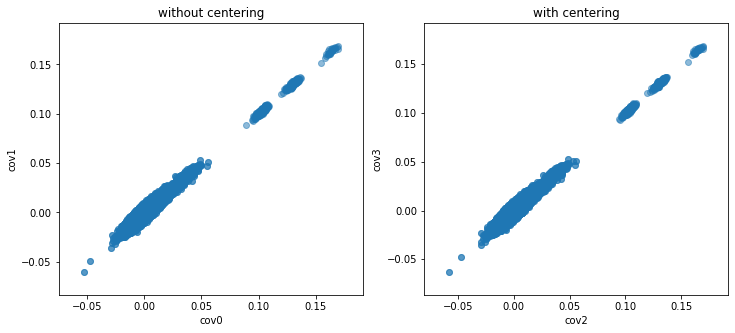

In [96]:
# compare effect of weights
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(cov0.ravel(), cov1.ravel(), alpha=0.5)
plt.xlabel("cov0")
plt.ylabel("cov1")
plt.title('without centering')
plt.subplot(122)
plt.scatter(cov2.ravel(), cov3.ravel(), alpha=0.5)
plt.xlabel("cov2")
plt.ylabel("cov3")
plt.title('with centering')

Text(0.5, 1.0, 'with weights')

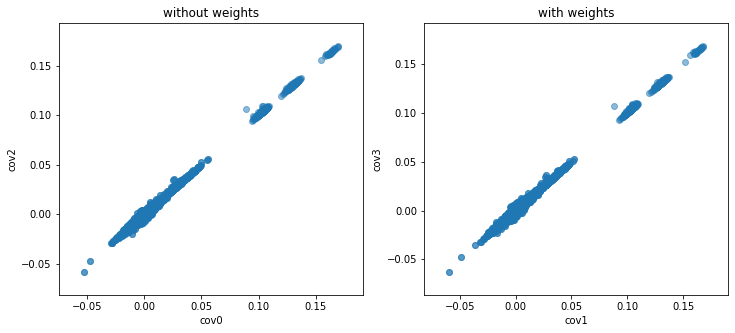

In [97]:
# compare effects of centering
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(cov0.ravel(), cov2.ravel(), alpha=0.5)
plt.xlabel("cov0")
plt.ylabel("cov2")
plt.title('without weights')
plt.subplot(122)
plt.scatter(cov1.ravel(), cov3.ravel(), alpha=0.5)
plt.xlabel("cov1")
plt.ylabel("cov3")
plt.title('with weights')

Text(0.5, 1.0, 'with weights')

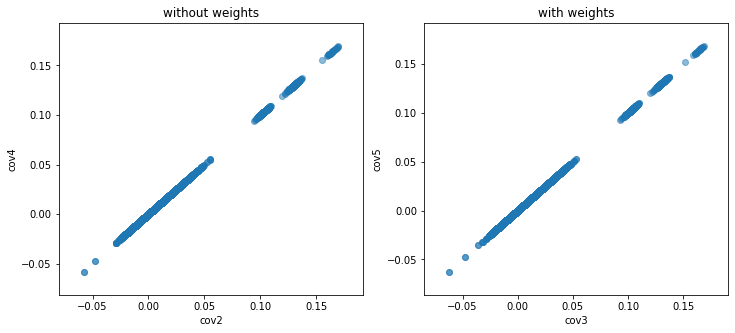

In [98]:
# compare classic vs. robust PCAs
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(cov2.ravel(), cov4.ravel(), alpha=0.5)
plt.xlabel("cov2")
plt.ylabel("cov4")
plt.title('without weights')
plt.subplot(122)
plt.scatter(cov3.ravel(), cov5.ravel(), alpha=0.5)
plt.xlabel("cov3")
plt.ylabel("cov5")
plt.title('with weights')

In [93]:
# data_row = 
# data_row.shape
# np.concatenate((data_row,data_row)).shape


# #plt.hist()

# print(np.max(spike_count))
data_stacked = stc.inflate_data_using_weights(spike_triggered_stim_row-center, spike_count)
# print(np.max(spike_count))
print(data_stacked.shape)
print(np.sum(spike_count))

(483, 512)
483


In [ ]:
#eig_values, eig_vectors = stc.calc_eig_values_and_vectors(cov0) # same as sklearn PCA
#eig_values, eig_vectors = stc.calc_eig_values_and_vectors(cov1) 
#eig_values, eig_vectors = stc.calc_eig_values_and_vectors(cov2)  # similar to sklean PCA
eig_values, eig_vectors = stc.calc_eig_values_and_vectors(cov3)   # everyting becomes larger



# eigenvalues (sklena PCA)
plt.plot(pca.explained_variance_, "o--")
plt.ylabel('eigenvalues')

# my code 
plt.plot(eig_values, "s--")

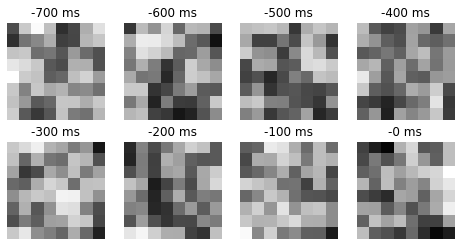

In [22]:
# the 1st eigen vector
pysta.plot_stim_slices(eig_vectors[:,0], vmin=-0.1, vmax=0.1, dt=dt)
# pysta.plot_stim_slices(pca.components_[0], dt=dt)

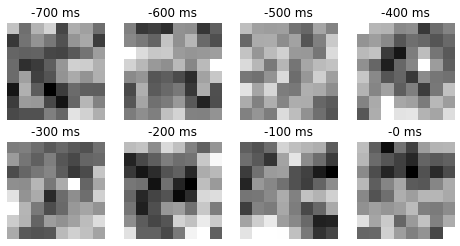

In [23]:
# the 2nd eigen vector
pysta.plot_stim_slices(eig_vectors[:,1], vmin=-0.1, vmax=0.1, dt=dt)
# pysta.plot_stim_slices(pca.components_[0], dt=dt)

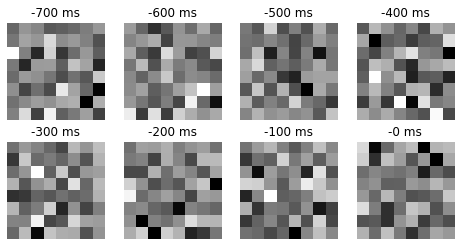

In [24]:
# the 2nd eigen vector
pysta.plot_stim_slices(eig_vectors[:,-1], vmin=-0.1, vmax=0.1, dt=dt) # something?
# pysta.plot_stim_slices(pca.components_[1], dt=dt)

In [25]:
projected = stc.project(spike_triggered_stim_row-center, eig_vectors)

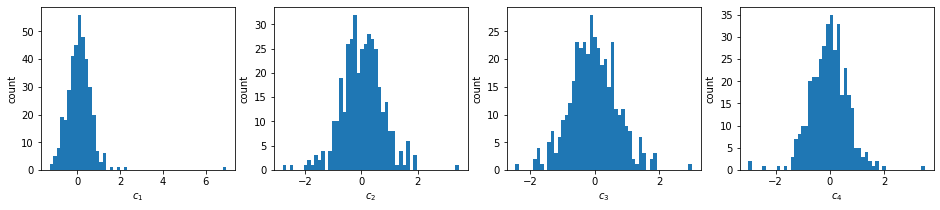

In [26]:
# projected scores 
num_figs = 4
plt.figure(figsize=(4*num_figs, 3))
for i in range(num_figs):
    plt.subplot(1, num_figs, i+1)
    plt.hist(projected[:,i], 50)
    plt.xlabel("$c_{}$".format(i+1))
    plt.ylabel('count')

plt.savefig(os.path.join(result_folder_name, "{}_coef_hist.pdf".format(channel_name)))    


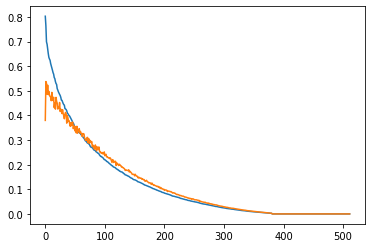

In [27]:
# compare eigenvalue vs actual variance
plt.plot(eig_values)

v = [np.var(projected[:,i]) for i in range(len(eig_values))]
plt.plot(v)

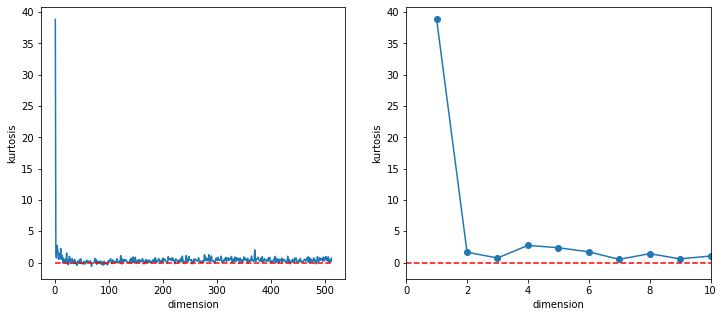

In [28]:
# calc & plot kurtosis
from scipy.stats import kurtosis

Ks = list()
dim = projected.shape[1]
for i in range(dim):    
    Ks.append(kurtosis(projected[:,i]))

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.linspace(1,dim,dim), Ks)
plt.plot([0,dim], [0,0], 'r--')
plt.ylabel('kurtosis')
plt.xlabel('dimension')

plt.subplot(122)
plt.plot(np.linspace(1,dim,dim), Ks, 'o-')
plt.plot([0,dim], [0,0], 'r--')
plt.xlim(0, 10)
plt.ylabel('kurtosis')
plt.xlabel('dimension') 

plt.savefig(os.path.join(result_folder_name, "{}_kurtosis.pdf".format(channel_name)))

projected center [[0. 0.]]
projected sta [[ 0.20742362 -0.01421998]]
projected zeros [[-1.70603024 -1.25509366]]
projected sta [[0. 0.]]
projected ones [[1.70603024 1.25509366]]


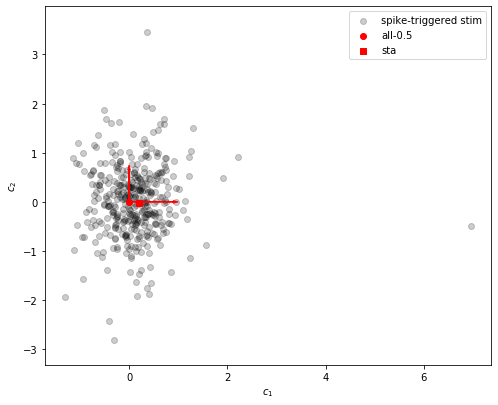

In [29]:
projected_center = stc.project(center-center, eig_vectors)
print("projected center", projected_center[:,0:2])

projected_sta = stc.project(sta.reshape([1,dim])-center, eig_vectors) # + pca.transform(center)
print("projected sta", projected_sta[:,0:2])

projected_zeros = stc.project(np.zeros([1,dim])-center, eig_vectors) # + pca.transform(center)
print("projected zeros", projected_zeros[:,0:2])

projected_halfs = stc.project(0.5*np.ones([1,dim])-center, eig_vectors) # + pca.transform(center)
print("projected sta", projected_halfs[:,0:2])

projected_ones = stc.project(np.ones([1,dim])-center, eig_vectors) # + pca.transform(center)
print("projected ones", projected_ones[:,0:2])


fig = plt.figure(figsize=(8,6.6))
ax = fig.add_subplot(111, aspect='equal')

plt.scatter(projected[:,0], projected[:,1], c='k', alpha=0.2)
#plt.scatter(projected[:,0], projected[:,1], alpha=0.2)

plt.xlabel("$c_1$")
plt.ylabel("$c_2$")
    

# plt.scatter(projected_zeros[:,0], projected_zeros[:,1], c='r', marker='^')
plt.scatter(projected_halfs[:,0], projected_halfs[:,1], c='r', marker='o')
# plt.scatter(projected_ones[:,0], projected_ones[:,1], c='r', marker="v")

plt.scatter(projected_sta[:,0], projected_sta[:,1], c='r', marker="s")

plt.legend(["spike-triggered stim", "all-0.5", "sta"])
# plt.legend(["spike-triggered stim", "all-zero", "all-0.5", "all-one", "sta"])
plt.axis('tight')
plt.axis('equal')

x = projected_center[0][0]
y = projected_center[0][1]
ax.arrow(x, y, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='r', ec='r')
ax.arrow(x, y, 0, 0.75, head_width=0.05, length_includes_head=True, head_length=0.1, fc='r', ec='r')


plt.savefig(os.path.join(result_folder_name, "{}_pca.pdf".format(channel_name)))
plt.savefig(os.path.join(result_folder_name, "{}_pca.png".format(channel_name)))

[[ 0.80550234  0.59259259]
 [-0.59259259  0.80550234]]
[[-2.11797056  0.        ]]
[[2.11797056 0.        ]]
0.47215009535190977


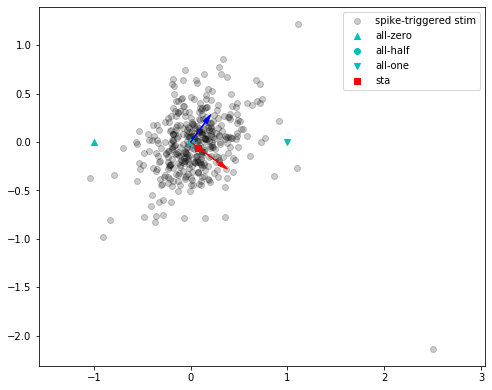

In [30]:
## replot with rotation!

R = pysta.calc_rotation_matrix(projected_zeros)
print(R)
print(np.dot(projected_zeros[:,:2],R.T))
print(np.dot(projected_ones[:,:2],R.T))

scale = -1/np.dot(projected_zeros[:,:2],R.T)[0][0]
print(scale)
# looks good

# re-plot with rotation
def plot_with_rotation(projected, R, c='k', alpha=1, marker='o'):
    
    rotated = np.dot(projected[:,:2], R.T)
    
    plt.scatter(rotated[:,0], rotated[:,1], c=c, marker=marker, alpha=alpha)

fig = plt.figure(figsize=(8,6.6))
ax = fig.add_subplot(111, aspect='equal')


plot_with_rotation(projected, R*scale, alpha=0.2)
# plt.xlabel("$c_1$")
# plt.ylabel("$c_2$")
    
plot_with_rotation(projected_zeros, R*scale, c='c', marker='^')
plot_with_rotation(projected_halfs, R*scale, c='c', marker='o')
plot_with_rotation(projected_ones, R*scale, c='c', marker='v')

plot_with_rotation(projected_sta, R*scale, c='r', marker='s')

plt.legend(["spike-triggered stim", "all-zero", "all-half", "all-one", "sta"])
plt.axis('tight')
plt.axis('equal')

x = projected_center[0][0]
y = projected_center[0][1]

rotated_xy = np.dot([x,y],scale*R.T)
rotated_arrow_head = np.dot([1,0], scale*R.T)
ax.arrow(rotated_xy[0], rotated_xy[1], rotated_arrow_head[0], rotated_arrow_head[1], head_width=0.05, length_includes_head=True, head_length=0.1, fc='r', ec='r')
rotated_arrow_head = np.dot([0,0.75], scale*R.T)
ax.arrow(rotated_xy[0], rotated_xy[1], rotated_arrow_head[0], rotated_arrow_head[1], head_width=0.05, length_includes_head=True, head_length=0.1, fc='b', ec='b')

plt.savefig(os.path.join(result_folder_name, "{}_pca_rotated.png".format(channel_name)))
plt.savefig(os.path.join(result_folder_name, "{}_pca_rotated.pdf".format(channel_name)))

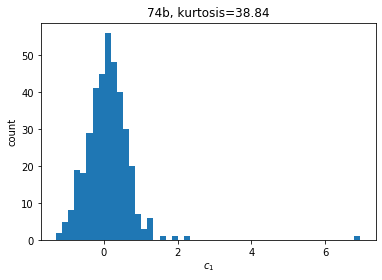

In [31]:
# further analyze the projected coefficients
coef = projected[:,0]
#np.savetxt('projected_coef.txt', projected[:,0])
plt.hist(coef, 50)
plt.xlabel("$c_1$")
plt.ylabel("count")
    

from scipy.stats import kurtosis
#scipy.stats.kurtosis
kurtosis(coef)

plt.title("{}, kurtosis={:.2f}".format(channel_name,kurtosis(coef)))

plt.savefig(os.path.join(result_folder_name, "{}_c1.pdf".format(channel_name)))

In [32]:
# fit mixture of Gaussians
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, n_init=10, means_init=[[np.mean(coef[coef<0])],[np.mean(coef[coef>0])]])
gm.fit(coef.reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=array([[-0.39381756],
       [ 0.43625071]]),
                n_components=2, n_init=10, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [33]:
gm.weights_

array([0.98825013, 0.01174987])

In [34]:
gm.means_

array([[0.06762216],
       [2.5151441 ]])

In [35]:
gm.covariances_

array([[[0.23670143]],

       [[6.51484933]]])

In [36]:
gm.covariances_[0][0,0]

0.23670143238814537

In [37]:
gm.covariances_[1][0,0]

6.51484932717184

In [38]:
gm.means_[0][0]

0.06762216387931935

In [39]:
gm.means_[1][0]

2.515144095523554

In [40]:
gm.converged_

True

In [41]:
gm.n_iter_

31

In [42]:
pred = gm.predict(coef.reshape(-1,1))
set(pred)

{0, 1}

In [43]:
# calc centers from stim
stim0 = spike_triggered_stim_row[pred==0,:]
stim1 = spike_triggered_stim_row[pred==1,:]

In [44]:
sta0 = np.average(spike_triggered_stim_row[pred==0,:], axis=0, weights=spike_count[pred==0])
sta1 = np.average(spike_triggered_stim_row[pred==1,:], axis=0, weights=spike_count[pred==1])

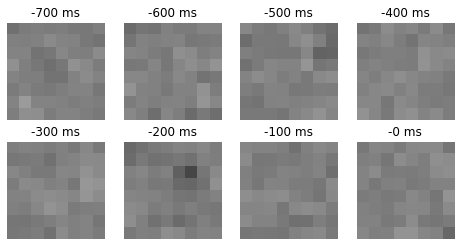

In [45]:
pysta.plot_stim_slices(sta0, dt=dt)
plt.savefig(os.path.join(result_folder_name, "{}_center_1.png".format(channel_name)))

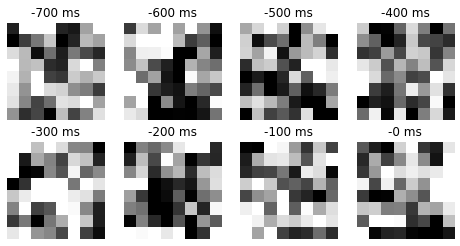

In [46]:
pysta.plot_stim_slices(sta1, dt=dt)
plt.savefig(os.path.join(result_folder_name, "{}_center_2.png".format(channel_name)))

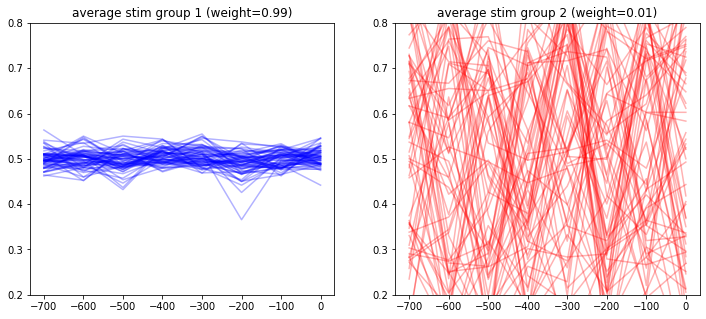

In [47]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
plt.plot(grid_T, sta0.reshape([8*8,-1]).T, 'b', alpha=0.3)
ax.set_ylim(0.2,0.8)
plt.title("average stim group 1 (weight={:.2f})".format(gm.weights_[0]))

ax=plt.subplot(122)
plt.plot(grid_T,sta1.reshape([8*8,-1]).T, 'r', alpha=0.3)
ax.set_ylim(0.2,0.8)
plt.title("average stim group 2 (weight={:.2f})".format(gm.weights_[1]))


plt.savefig(os.path.join(result_folder_name, "{}_centers_temporal.pdf".format(channel_name)))
plt.savefig(os.path.join(result_folder_name, "{}_centers_temporal.png".format(channel_name)))

In [48]:
gm.weights_[0]

0.9882501250178045

## further analysis

Counter({0: 378, 1: 3})


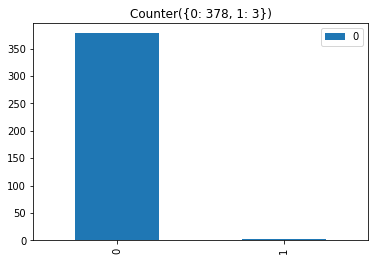

In [49]:
# is there a temporal pattern?
#plt.hist(pred)
from collections import Counter
pred_counts = Counter(pred)
print(pred_counts)
df = pd.DataFrame.from_dict(pred_counts, orient='index')
df.plot(kind='bar')

plt.title(pred_counts)

plt.savefig(os.path.join(result_folder_name, "{}_group_hist.pdf".format(channel_name)))
plt.savefig(os.path.join(result_folder_name, "{}_group_hist.png".format(channel_name)))

## use more dimensions

In [50]:
dim = 1
cl = stcl.fit(projected[:,:dim], coef)

pred1 = cl.predict(projected[:,:dim])
# set(pred2)

centers1 = stcl.calc_centers(spike_triggered_stim_row, spike_count, pred1)

converged= True
means= [[2.51355372]
 [0.06761872]]
covariances= [[[6.51384635]]

 [[0.23669383]]]
weights= [0.01175891 0.98824109]


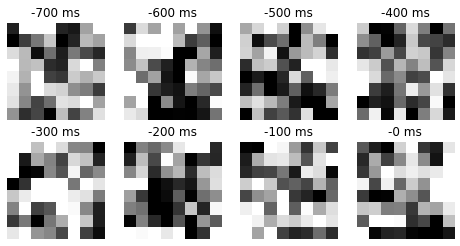

In [51]:
pysta.plot_stim_slices(centers1[0], dt=dt)
# plt.savefig("{}_1d_center_0.png".format(channel_name))

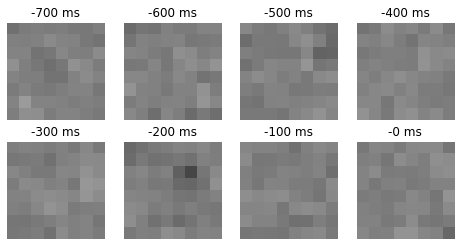

In [52]:
pysta.plot_stim_slices(centers1[1], dt=dt)
# plt.savefig("{}_1d_center_1.png".format(channel_name))

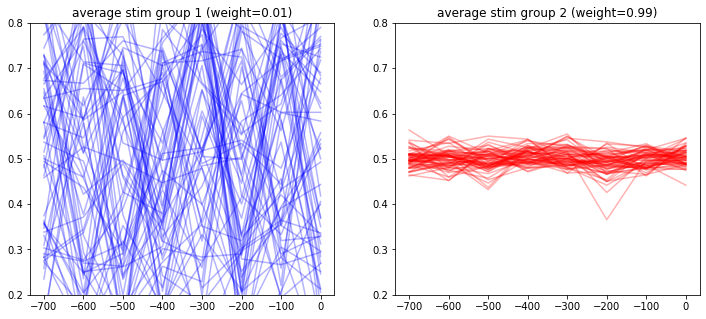

In [53]:
stcl.plot_centers(centers1, grid_T, cl.weights_)

In [54]:
dim = 2
cl = stcl.fit(projected[:,:dim], coef)

pred2 = cl.predict(projected[:,:dim])
# set(pred2)

centers2 = stcl.calc_centers(spike_triggered_stim_row, spike_count, pred2)

converged= True
means= [[ 0.06804293  0.03099752]
 [ 0.90591839 -0.07789943]]
covariances= [[[0.22621905 0.00484701]
  [0.00484701 0.46082173]]

 [[4.09573474 0.39764799]
  [0.39764799 2.72755988]]]
weights= [0.96617957 0.03382043]


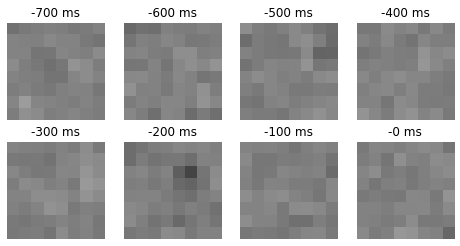

In [55]:
pysta.plot_stim_slices(centers2[0], dt=dt)
plt.savefig(os.path.join(result_folder_name, "{}_center_2d_1.png".format(channel_name)))

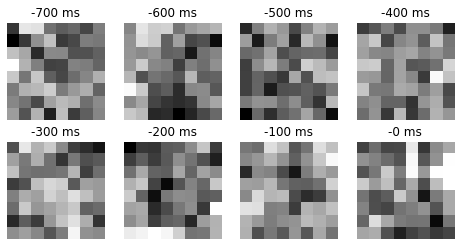

In [56]:
pysta.plot_stim_slices(centers2[1], dt=dt)
plt.savefig(os.path.join(result_folder_name, "{}_center_2d_2.png".format(channel_name)))

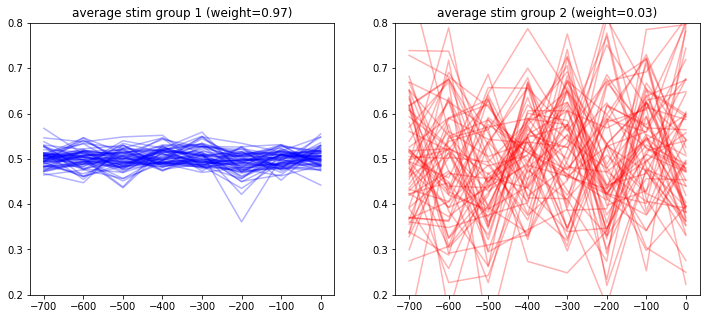

In [57]:
stcl.plot_centers(centers2, grid_T, cl.weights_)

In [58]:
from sklearn.metrics import confusion_matrix

confusion_matrix(pred1,pred2)

array([[  0,   3],
       [373,   5]])

In [59]:
dim = 3
cl = stcl.fit(projected[:,:dim], coef)

pred3 = cl.predict(projected[:,:dim])
set(pred3)

centers3 = stcl.calc_centers(spike_triggered_stim_row, spike_count, pred3)

converged= True
means= [[ 0.06232024  0.05180724 -0.06090693]
 [ 0.83532757 -0.50406501  0.46765461]]
covariances= [[[ 0.22468383  0.00875517  0.03866246]
  [ 0.00875517  0.43661483 -0.01842115]
  [ 0.03866246 -0.01842115  0.44519237]]

 [[ 3.17907693  0.56465407 -0.2960265 ]
  [ 0.56465407  2.43929763  0.38413951]
  [-0.2960265   0.38413951  2.11670105]]]
weights= [0.95593833 0.04406167]


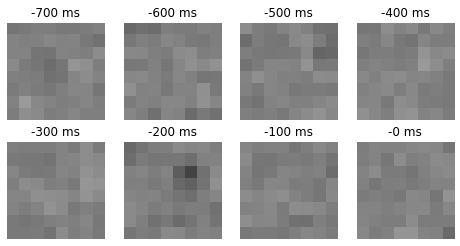

In [60]:
pysta.plot_stim_slices(centers3[0], dt=dt)
plt.savefig(os.path.join(result_folder_name, "{}_center_3d_1.png".format(channel_name)))

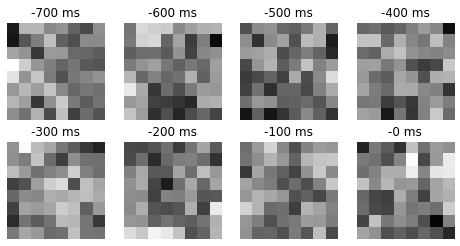

In [61]:
pysta.plot_stim_slices(centers3[1], dt=dt)
plt.savefig(os.path.join(result_folder_name, "{}_center_3d_2.png".format(channel_name)))

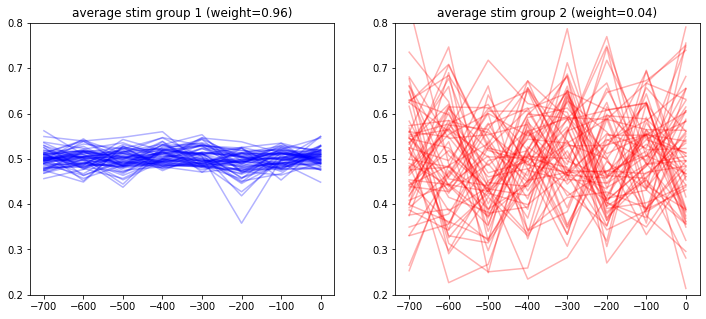

In [62]:
stcl.plot_centers(centers3, grid_T, cl.weights_)

In [63]:
from sklearn.metrics import confusion_matrix

confusion_matrix(pred2,pred3)

array([[370,   3],
       [  0,   8]])

In [64]:
# increase dimension to 5

dim = 5
cl = stcl.fit(projected[:,:dim], coef)

pred3 = cl.predict(projected[:,:dim])
set(pred3)

centers3 = stcl.calc_centers(spike_triggered_stim_row, spike_count, pred3)

converged= True
means= [[ 0.05672064  0.0597998  -0.07605009 -0.03359637 -0.00871442]
 [ 0.608456   -0.39212738  0.45861368 -0.06376112  0.13502571]]
covariances= [[[ 0.22147427  0.00921102  0.02946099  0.00568181  0.00881809]
  [ 0.00921102  0.39773215 -0.00255026 -0.03105968 -0.03970023]
  [ 0.02946099 -0.00255026  0.43101659 -0.00705625 -0.03086969]
  [ 0.00568181 -0.03105968 -0.00705625  0.35249848 -0.01933388]
  [ 0.00881809 -0.03970023 -0.03086969 -0.01933388  0.40832144]]

 [[ 2.14470587  0.32325681 -0.08205925  0.09452767 -0.06287826]
  [ 0.32325681  2.1577589   0.07551338  0.20711652  0.27992775]
  [-0.08205925  0.07551338  1.55121074  0.03067411  0.12025104]
  [ 0.09452767  0.20711652  0.03067411  2.21764463  0.06775465]
  [-0.06287826  0.27992775  0.12025104  0.06775465  1.98739162]]]
weights= [0.92811844 0.07188156]


In [65]:
cl.covariances_[0]

array([[ 0.22147427,  0.00921102,  0.02946099,  0.00568181,  0.00881809],
       [ 0.00921102,  0.39773215, -0.00255026, -0.03105968, -0.03970023],
       [ 0.02946099, -0.00255026,  0.43101659, -0.00705625, -0.03086969],
       [ 0.00568181, -0.03105968, -0.00705625,  0.35249848, -0.01933388],
       [ 0.00881809, -0.03970023, -0.03086969, -0.01933388,  0.40832144]])

In [66]:
cl.covariances_[1]

array([[ 2.14470587,  0.32325681, -0.08205925,  0.09452767, -0.06287826],
       [ 0.32325681,  2.1577589 ,  0.07551338,  0.20711652,  0.27992775],
       [-0.08205925,  0.07551338,  1.55121074,  0.03067411,  0.12025104],
       [ 0.09452767,  0.20711652,  0.03067411,  2.21764463,  0.06775465],
       [-0.06287826,  0.27992775,  0.12025104,  0.06775465,  1.98739162]])

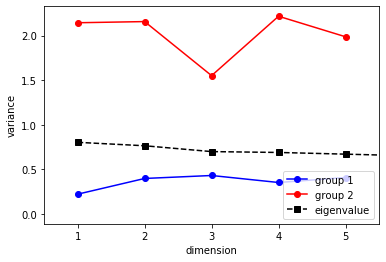

In [67]:
dims = np.linspace(1,dim,dim)
plt.plot(dims, np.diag(cl.covariances_[0]), '-bo')
plt.plot(dims, np.diag(cl.covariances_[1]), '-ro')
dims = np.linspace(1,len(eig_values), len(eig_values))
plt.plot(dims, eig_values, '--ks')

plt.xlim(0.5,5.5)
plt.xlabel('dimension')
plt.ylabel('variance')

plt.legend(['group 1', 'group 2', 'eigenvalue'], loc='lower right')

plt.savefig(os.path.join(result_folder_name, "{}_variances.png".format(channel_name)))
plt.savefig(os.path.join(result_folder_name, "{}_variances.pdf".format(channel_name)))

## Isolation forest
https://github.com/ys7yoo/hands-on/blob/master/anomaly_comparison.ipynb

In [68]:
# from sklearn.ensemble import IsolationForest

# outliers_fraction = 0.15
# iso = IsolationForest(contamination=outliers_fraction, behaviour="new", random_state=42)

# # iso.fit(spike_triggered_stim_row-0.5)
# # pred=iso.predict(spike_triggered_stim_row-0.5)
# pred = iso.fit_predict(spike_triggered_stim_row-0.5)

In [69]:
# # re-fit PCA with inliers
# #pca = PCA(n_components = 2, whiten=True)
# pca = PCA(n_components = 2)
# projected = pca.fit_transform(spike_triggered_stim_row[pred>0,:]-0.5)
# projected += pca.transform(0.5*np.ones([1,640]))

# pca.explained_variance_ratio_

In [70]:
# projected_sta = pca.transform(sta.reshape([1,640])-0.5) + pca.transform(0.5*np.ones([1,640]))


# projected_zero = pca.transform(np.zeros([1,640])-0.5) + pca.transform(0.5*np.ones([1,640]))
# projected_ones = pca.transform(np.ones([1,640])-0.5) + pca.transform(0.5*np.ones([1,640]))

# plt.figure(figsize=(8,6.6))

# plt.scatter(projected[:,0], projected[:,1], alpha=0.5)
# # plt.scatter(projected[pred>0,0], projected[pred>0,1], alpha=0.5)
# # plt.scatter(projected[pred<0,0], projected[pred<0,1], alpha=0.5, c="k")

# plt.scatter(projected_sta[:,0], projected_sta[:,1], c='k', marker="*")
# plt.scatter(projected_zero[:,0], projected_zero[:,1], c='r', marker='o')
# plt.scatter(projected_ones[:,0], projected_ones[:,1], c='r', marker="s")
# #plt.scatter(projected_negative_ones[:,0], projected_negative_ones[:,1], c='r', marker="^")

# plt.legend(["spike-triggered stim", "sta", "all-zero", "all-one"])

# x = projected_sta[0][0]
# y = projected_sta[0][1]
# ax.arrow(x, y, 0, 0.5, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
# ax.arrow(x, y, 0.5, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')


# #plt.scatter(projected_negative_ones[:,0], projected_negative_ones[:,1], c='r', marker="^")
# plt.axis('tight')
# plt.axis('equal')

# # plt.savefig("iso_forest_pca_{}.png".format(channel_name))

In [71]:
# projected.shape

## How about STC?

In [72]:
# # calc covariance matrix
# num_samples = smoothed_spike_triggered_stim.shape[0]

# center = np.mean(spike_triggered_stim_row, axis=0, keepdims=True)
# data_centered = spike_triggered_stim_row - center


# covariance_mat = stc.calc_covariance_matrix(data_centered)
# #robust_covariance_mat = make_robust_covariance_mat(data_centered, centered=True)

In [73]:
# eig_values, eig_vectors = stc.calc_eig_values_and_vectors(covariance_mat)

# plt.plot(eig_values, 'o--')
# plt.plot(pca.explained_variance_, 's:')  # to compare with sklearn PCA
# print(eig_values[-1])

In [74]:
# pysta.plot_stim_slices(eig_vectors[:,0])

In [75]:
# plt.scatter(pca.components_[0], eig_vectors[:,0])

In [76]:
# # project 
# projected = stc.project(data_centered, eig_vectors)# [:,0:7]

# dim = data_centered.shape[1]
# projected_all_one = stc.project(np.ones([1,dim]) - center, eig_vectors)
# projected_all_zero = stc.project(np.zeros([1,dim]) - center, eig_vectors)

# plt.scatter(projected[:,0], projected[:,1], color='k')
# plt.scatter(projected_all_one[:,0], projected_all_one[:,1], color='r', marker='^')
# plt.scatter(projected_all_zero[:,0], projected_all_zero[:,1], color='b', marker='v')

In [77]:
# num_figs = 4
# plt.figure(figsize=(4*num_figs, 3))
# for i in range(num_figs):
#     plt.subplot(1, num_figs, i+1)
#     plt.hist(projected[:,i], 50)